# MagPySV example workflow - European observatories

# Setup

In [1]:
# Setup python paths and import some modules
from IPython.display import Image
import sys
sys.path.append('..')
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# Import all of the MagPySV modules
import magpysv.denoise as denoise
import magpysv.io as io
import magpysv.model_prediction as model_prediction
import magpysv.plots as plots
import magpysv.tools as tools

In [2]:
%matplotlib notebook

# Downloading data

In [3]:
from lib import consume_webservices as cws

wdc_app_path = '/Users/gracecox/geomag_wdc_web_app_interface/'
sys.path.append(wdc_app_path)
cadence = 'hour'

start_date = dt.date(1960, 1, 1)
end_date = dt.date(2009, 12, 31)
service = 'WDC'
download_dir = './data/'
configpath = os.path.join(wdc_app_path, 'lib/consume_rest.ini')

observatory_list = ['CLF', 'NGK', 'WNG']

[
cws.fetch_data(
        start_date, end_date,
        observatory_, cadence,
        service, download_dir, configpath
)
for observatory_ in observatory_list]

[None, None, None]

In [ ]:
observatory_list = ['CLF', 'NGK', 'WNG']
download_dir = '/Users/gracecox/Desktop/download_test/'

# Initial processing

Extract all data from the WDC files, convert into the proper hourly means using the tabular base and save the X, Y and Z components to CSV files.

In [4]:
io.wdc_to_hourly_csv(wdc_path=download_dir, write_path=download_dir + '/hourly/', obs_list=observatory_list,
                  print_obs=True)

CLF
./data/clf1960.wdc
./data/clf1961.wdc
./data/clf1962.wdc
./data/clf1963.wdc
./data/clf1964.wdc
./data/clf1965.wdc
./data/clf1966.wdc
./data/clf1967.wdc
./data/clf1968.wdc
./data/clf1969.wdc
./data/clf1970.wdc
./data/clf1971.wdc
./data/clf1972.wdc
./data/clf1973.wdc
./data/clf1974.wdc
./data/clf1975.wdc
./data/clf1976.wdc
./data/clf1977.wdc
./data/clf1978.wdc
./data/clf1979.wdc
./data/clf1980.wdc
./data/clf1981.wdc
./data/clf1982.wdc
./data/clf1983.wdc
./data/clf1984.wdc
./data/clf1985.wdc
./data/clf1986.wdc
./data/clf1987.wdc
./data/clf1988.wdc
./data/clf1989.wdc
./data/clf1990.wdc
./data/clf1991.wdc
./data/clf1992.wdc
./data/clf1993.wdc
./data/clf1994.wdc
./data/clf1995.wdc
./data/clf1996.wdc
./data/clf1997.wdc
./data/clf1998.wdc
./data/clf1999.wdc
./data/clf2000.wdc
./data/clf2001.wdc
./data/clf2002.wdc
./data/clf2003.wdc
./data/clf2004.wdc
./data/clf2005.wdc
./data/clf2006.wdc
./data/clf2007.wdc
./data/clf2008.wdc
./data/clf2009.wdc
NGK
./data/ngk1960.wdc
./data/ngk1961.wdc
./da

In [9]:
# Path to file containing baseline discontinuity information
baseline_data = tools.get_baseline_info(fname='baseline_records')

In [14]:
# Loop over all observatories and calculate SV series for each
for observatory in observatory_list:
    print(observatory)
    # Load hourly data
    data_file = observatory + '.csv'
    hourly_data = io.read_csv_data(
        fname=os.path.join(download_dir + 'hourly/', data_file),
        data_type='mf')
    # Resample to monthly means
    resampled_field_data = tools.data_resampling(hourly_data, sampling='MS', average_date=True)
    # Correct documented baseline changes
    tools.correct_baseline_change(observatory=observatory,
                          field_data=resampled_field_data,
                          baseline_data=baseline_data, print_data=True)
    # Write out the monthly means for magnetic field
    io.write_csv_data(data=resampled_field_data,
                            write_path=download_dir + 'monthly_mf/',
                            obs_name=observatory)
    # Calculate SV from monthly field means
    sv_data = tools.calculate_sv(resampled_field_data,
                                   mean_spacing=1)
    # Write out the SV data
    io.write_csv_data(data=sv_data,
                               write_path=download_dir + 'monthly_sv/fdmm/',
                               obs_name=observatory)

CLF
    observatory  jump_year  x_jump  y_jump  z_jump
115         CLF 1936-01-01    -387     -96     278
116         CLF 1957-01-01      35      -4      72
117         CLF 1968-01-01      -2     -18      11
118         CLF 1983-01-01       0      -9       1
Baseline change of unknown magnitude:  1983-01-01 00:00:00
NGK
   observatory  jump_year  x_jump  y_jump  z_jump
88         NGK 1996-01-01      -4       0       0
WNG
   observatory  jump_year  x_jump  y_jump  z_jump
78         WNG 1939-01-01      36    -193     -11
79         WNG 2004-01-01       2       3      -2


# Field model predictions

We need some secular variation predictions from a geomagnetic field model. This example uses COV-OBS. The following code obtains the complete list of geomagnetic observatory locations from the WDC website, converts the lat/lon in degrees to colat/lon in radians and altitude from m to km, and then runs the COV-OBS model for each location to produce files containing the model prediction of SV and MF at that location.

In [ ]:
stations = model_prediction.get_observatory_list()

In [ ]:
model_prediction.run_covobs(stations=stations, model_path='/Users/gracecox/Dropbox/cov-obs_x1/',
                            output_path='/Users/gracecox/Dropbox/cov-obs_x1/monthly_vals/')

# Residuals

Concatenate the data for our selected observatories.

In [15]:
# Start and end dates of the analysis as (year, month, day)
start = dt.datetime(1960, 1, 1)
end = dt.datetime(2010, 12, 31)

obs_data, model_sv_data, model_mf_data = io.combine_csv_data(
    start_date=start, end_date=end, obs_list=observatory_list,
    data_path=download_dir + 'monthly_sv/fdmm/',
    model_path="/Users/gracecox/Dropbox/field_models/cov-obs_x1/monthly_vals/", day_of_month=1)

dates = obs_data['date']

In [ ]:
obs_data

# SV plots

<IPython.core.display.Javascript object>


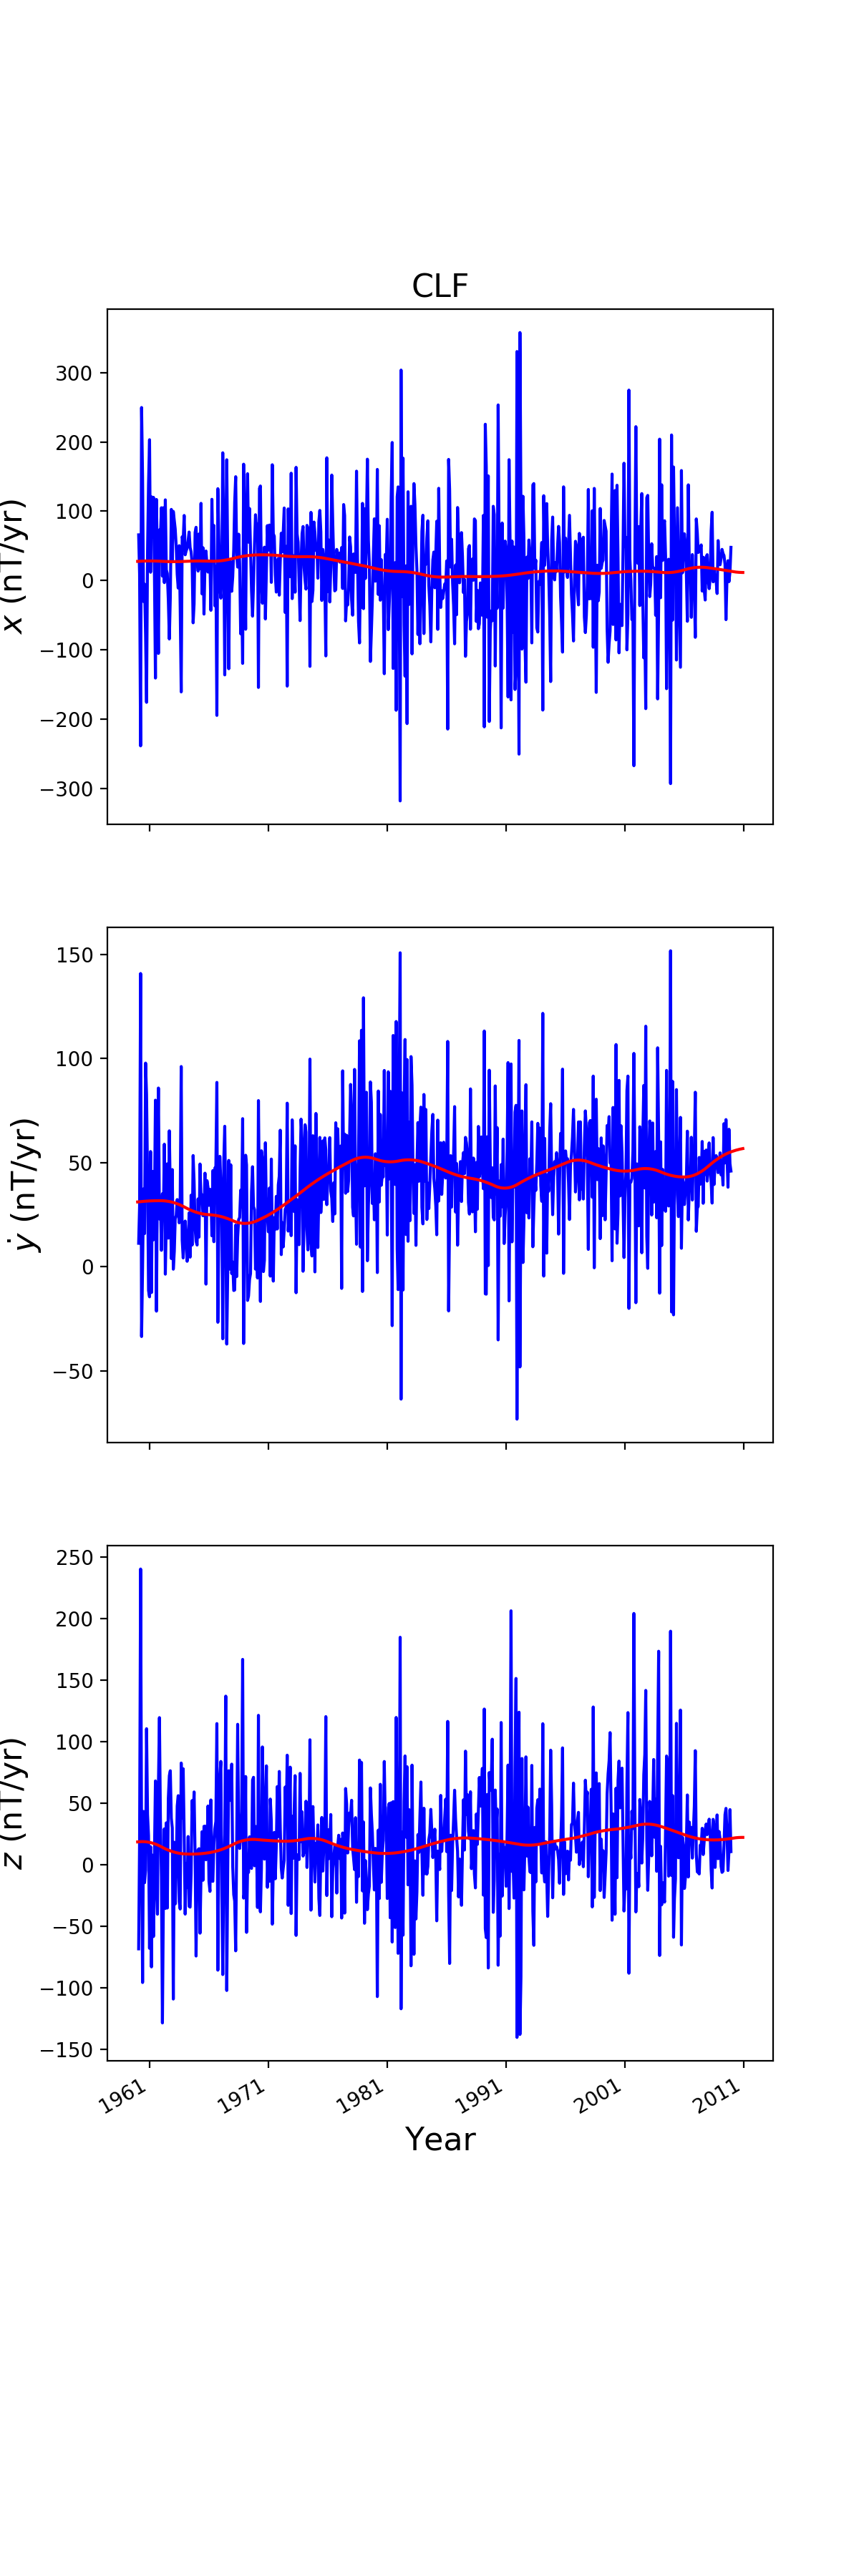

<IPython.core.display.Javascript object>


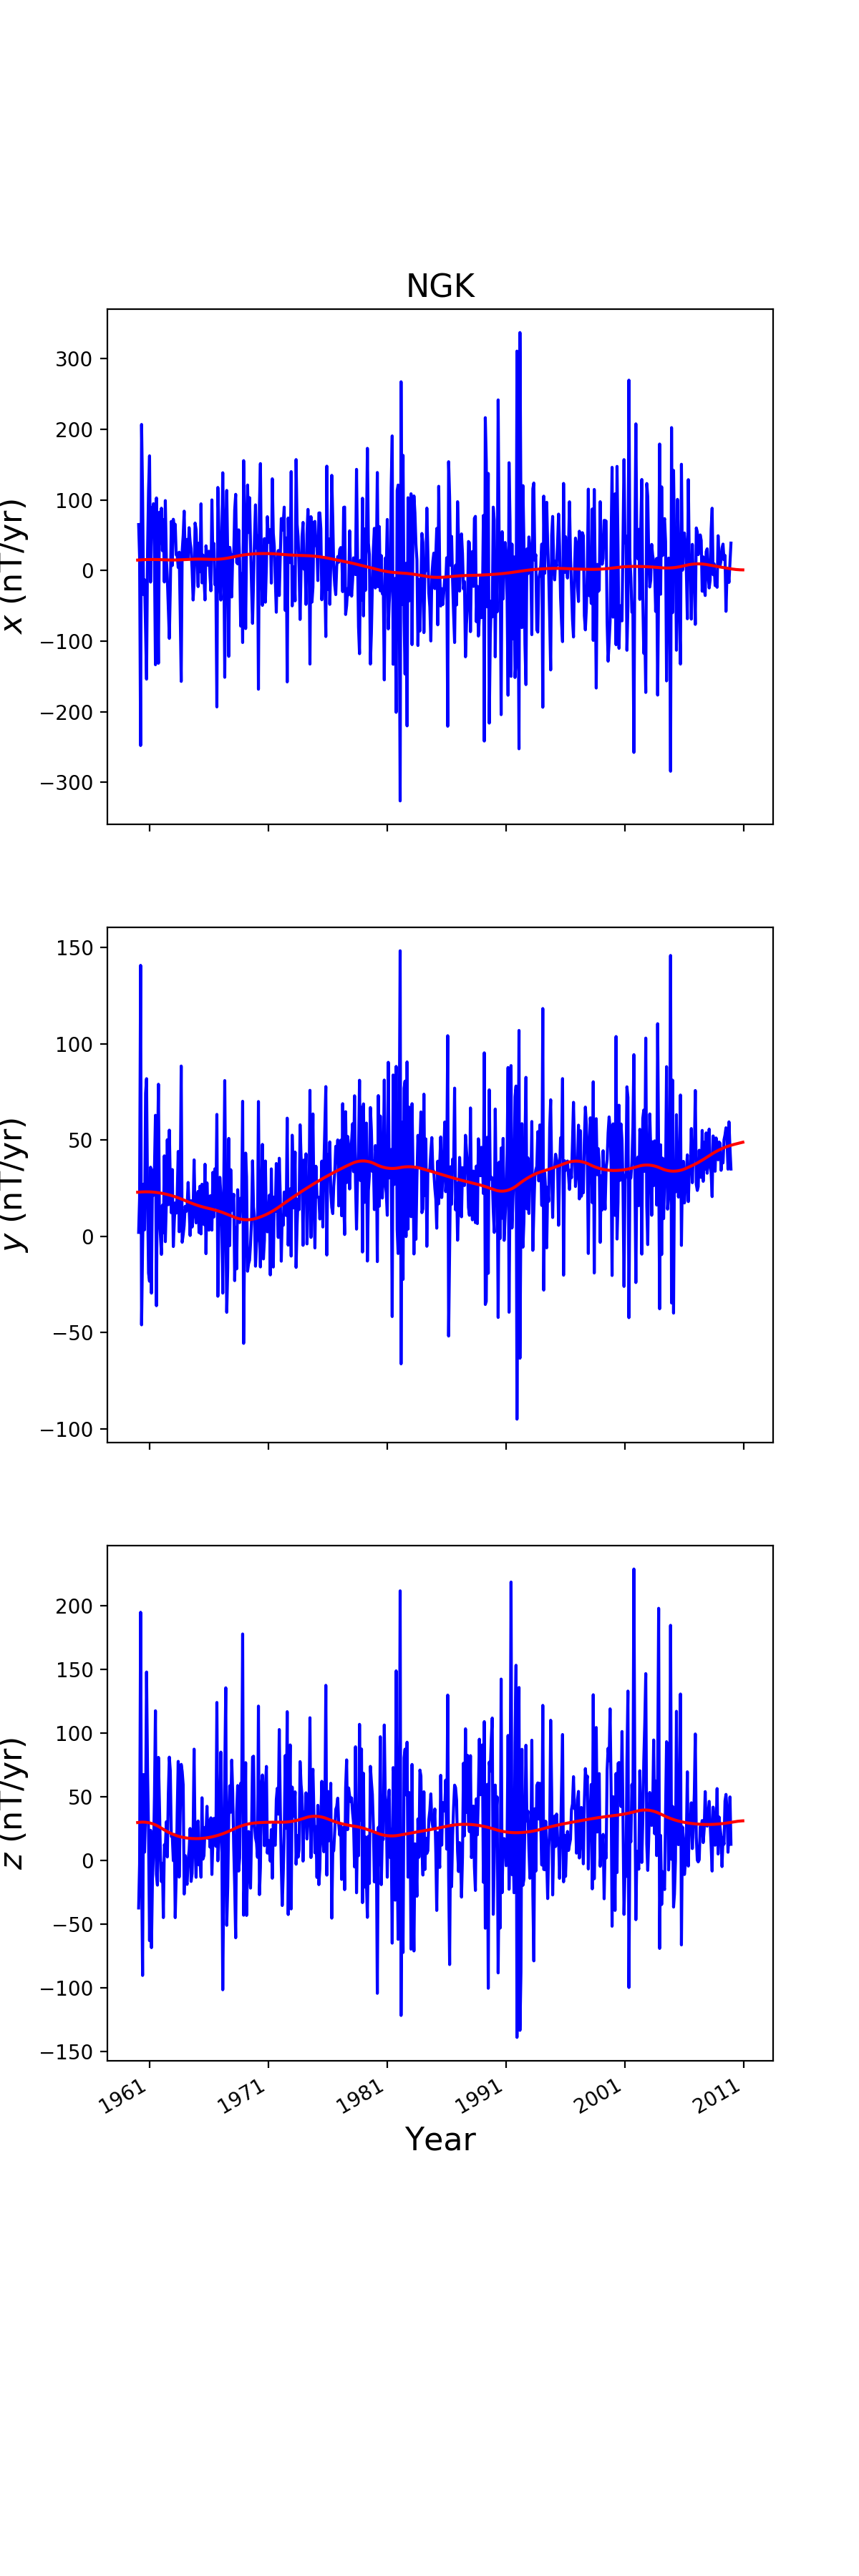

<IPython.core.display.Javascript object>


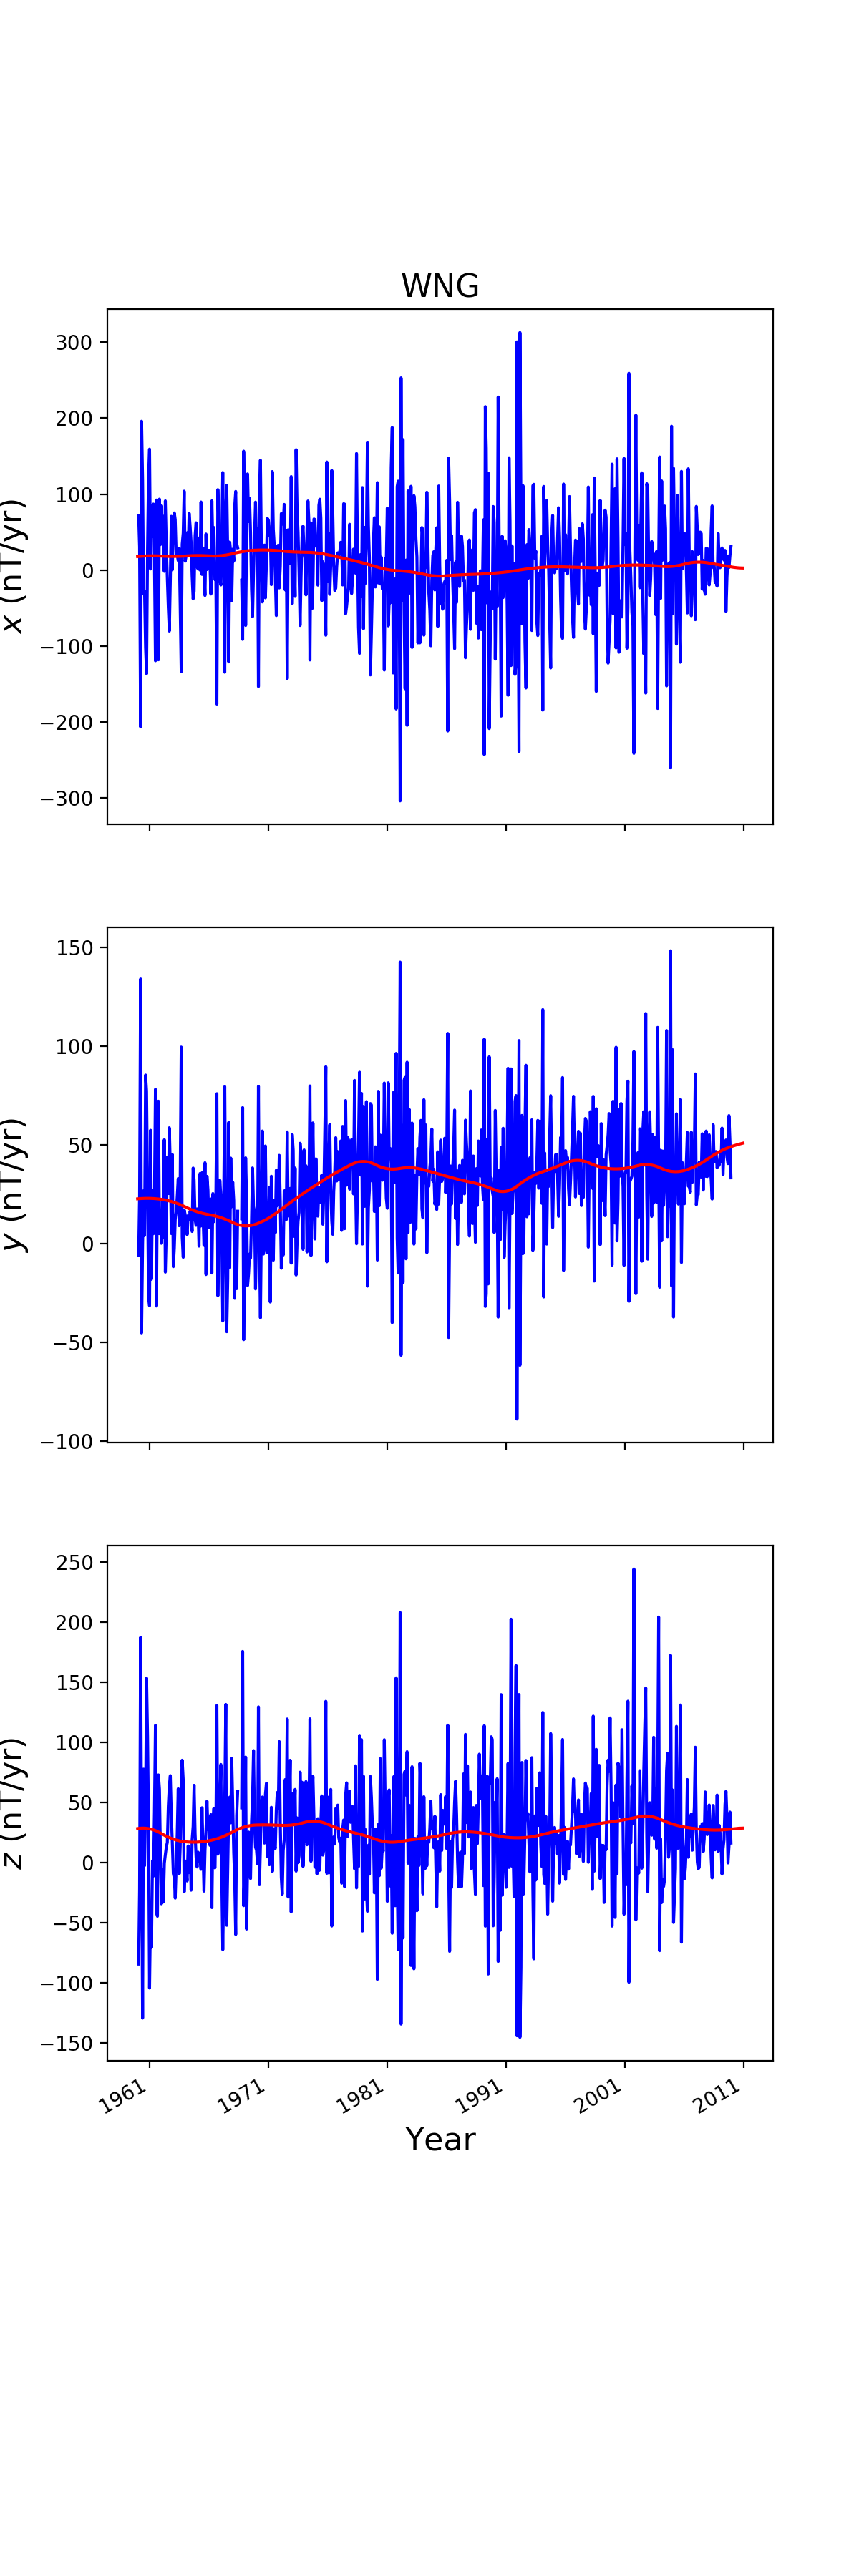

In [16]:
for observatory in observatory_list:
    fig = plots.plot_sv(dates=dates, sv=obs_data.filter(regex=observatory),
                    model=model_sv_data.filter(regex=observatory),
                    fig_size=(6, 18), font_size=10, label_size=16, plot_legend=False,
                    obs=observatory, model_name='COV-OBS')

# Outlier detection

Optionally remove spikes in the data before denoising. Large outliers can affect the denoising process so better to remove them beforehand for some series (i.e. at high latitude observatories).

In [ ]:
obs_data.drop(['date'], axis=1, inplace=True)
for column in obs_data:    
    obs_data[column] = denoise.detect_outliers(dates=dates, signal=obs_data[column], obs_name=column,
                                               threshold=4,
                                               window_length=96, plot_fig=True, fig_size=(4,4))
obs_data.insert(0, 'date', dates)

# External noise removal

Compute the residuals and use the eigenvalues/vectors of the covariance matrix to remove unmodelled external signal (Wardinski & Holme, 2011)

In [ ]:
residuals = tools.calculate_residuals(obs_data=obs_data, model_data=model_sv_data)

In [ ]:
model_sv_data.drop(['date'], axis=1, inplace=True)
obs_data.drop(['date'], axis=1, inplace=True)

In [ ]:
denoised, proxy, eigenvals, eigenvecs, projected_residuals, corrected_residuals = denoise.eigenvalue_analysis(
    dates=dates, obs_data=obs_data, model_data=model_sv_data, residuals=residuals,
    proxy_number=2)

# Denoised SV plots

Plots showing the original SV data, the denoised data (optionally with a running average) and the field model predictions.

In [ ]:
for observatory in observatory_list:
    xratio, yratio, zratio = plots.plot_sv_comparison(dates=dates, denoised_sv=denoised.filter(regex=observatory),
        residuals=residuals.filter(regex=observatory),
        corrected_residuals = corrected_residuals.filter(regex=observatory),
        noisy_sv=obs_data.filter(regex=observatory), model=model_sv_data.filter(regex=observatory),
        model_name='COV-OBS',
        fig_size=(10, 7), font_size=10, label_size=14, obs=observatory, plot_rms=True)

Plots showing the denoised data (optionally with a running average) and the field model predictions.

In [ ]:
for observatory in observatory_list:
    plots.plot_sv(dates=dates, sv=denoised.filter(regex=observatory), model=model_sv_data.filter(regex=observatory),
                    fig_size=(10, 5), font_size=10, label_size=14, plot_legend=False, obs=observatory, model_name='COV-OBS')

# Plot proxy signal, eigenvalues and eigenvectors

Compare the proxy signal used to denoise the data with the Dst index, measures the intensity of the equatorial electrojet (the "ring current"). Both signals are reduced to zero-mean and unit variance (z-score).

In [ ]:
dst_file = '/Users/gracecox/Dropbox/DataDownloads/Dst/dst_fdmm.csv'

In [ ]:
plots.plot_index_dft(index_file=dst_file, dates=denoised.date, signal=proxy, fig_size=(10, 8), font_size=10,
                       label_size=14, plot_legend=True, index_name='Dst')

Plot the eigenvalues of the covariance matrix of the residuals

In [ ]:
plots.plot_eigenvalues(values=eigenvals, font_size=12, label_size=16, fig_size=(8, 4))

Plot the three eigenvectors corresponding to the three largest eigenvalues. The noisiest direction (used to denoise in this example) is mostly X, with some Z, which is consistent with the ring current for European observatories. The second noisiest direction (also used to denoise in this example) is predominantly Z, with some X, which is again consistent with rind current directions. However, the third noisiest direction is a coherent Y signal across Europe, which does not correspond to a known direction of external signal. We did not remove this direction during denoising as it could be a real internal field variation that is not captured by the field model.

In [ ]:
plots.plot_eigenvectors(obs_names=observatory_list, eigenvecs=eigenvecs[:,0:3], fig_size=(8, 4),
                          font_size=10, label_size=16)

# Outlier detection

Remove remaining spikes in the time series.

In [ ]:
denoised.drop(['date'], axis=1, inplace=True)
for column in denoised:
    denoised[column] = denoise.detect_outliers(dates=dates, signal=denoised[column], obs_name=column, threshold=5,
                                               window_length=120, plot_fig=False, fig_size=(10, 3), font_size=10, label_size=14)
denoised.insert(0, 'date', dates)

# Write denoised data to file

In [ ]:
for observatory in observatory_list:
    print(observatory)
    sv_data=denoised.filter(regex=observatory)
    sv_data.insert(0, 'date', dates)
    sv_data.columns = ["date", "dX", "dY", "dZ"]
    io.write_csv_data(data=sv_data, write_path=download_dir + '/denoised/european/',
                               obs_name=observatory, decimal_dates=False)

# Averaging data over Europe

Select denoised data for each SV component at all observatories

In [ ]:
obs_X = denoised.filter(regex='dX')
model_X = model_sv_data.filter(regex='dX')
obs_Y = denoised.filter(regex='dY')
model_Y = model_sv_data.filter(regex='dY')
obs_Z = denoised.filter(regex='dZ')
model_Z = model_sv_data.filter(regex='dZ')

Average data and model for each component

In [ ]:
mean_X = pd.DataFrame(np.mean(obs_X.values, axis=1))
mean_X.columns = ['dX']
mean_model_X = np.mean(model_X, axis=1)
mean_Y = pd.DataFrame(np.mean(obs_Y.values, axis=1))
mean_Y.columns = ['dY']
mean_model_Y = np.mean(model_Y, axis=1)
mean_Z = pd.DataFrame(np.mean(obs_Z.values, axis=1))
mean_Z.columns = ['dZ']
mean_model_Z = np.mean(model_Z, axis=1)

Remove outliers from averaged data

In [ ]:
mean_X = denoise.detect_outliers(dates=dates, signal=mean_X, obs_name='X', threshold=2.5,
                                               window_length=72, plot_fig=False, fig_size=(10, 3), font_size=10, label_size=14)
mean_Y = denoise.detect_outliers(dates=dates, signal=mean_Y, obs_name='Y', threshold=2.5,
                                               window_length=72, plot_fig=False, fig_size=(10, 3), font_size=10, label_size=14)
mean_Z = denoise.detect_outliers(dates=dates, signal=mean_Z, obs_name='Z', threshold=2.5,
                                               window_length=72, plot_fig=False, fig_size=(10, 3), font_size=10, label_size=14)

Look at model predictions for all observatories, and the averaged model, to see if the average is representative of the trend at all locations

In [ ]:
plt.figure(figsize=(10,7))
plt.subplot(3, 1, 1)
plt.plot(dates, model_X)
plt.plot(dates, mean_model_X, 'k--')
legend = model_X.columns.tolist()
legend.append('Average')
plt.legend(legend, frameon=False)
plt.subplot(3, 1, 2)
plt.plot(dates, model_Y)
plt.plot(dates, mean_model_Y, 'k--')
plt.ylabel('SV (nT/yr)',  fontsize=16)
plt.subplot(3, 1, 3)
plt.plot(dates, model_Z)
plt.plot(dates, mean_model_Z, 'k--')
plt.xlabel('Year',  fontsize=16)

Plot the averaged data and model

In [ ]:
plt.figure(figsize=(10, 7))
plt.subplot(3,1,1)
plt.plot(dates, mean_X, 'b')
plt.plot(dates, np.mean(model_X, axis=1), 'r')
plt.subplot(3,1,2)
plt.plot(dates, mean_Y, 'b')
plt.plot(dates, np.mean(model_Y, axis=1), 'r')
plt.ylabel('SV (nT/yr)', fontsize=16)
plt.subplot(3,1,3)
plt.plot(dates, mean_Z, 'b', label='Averaged data')
plt.plot(dates, np.mean(model_Z, axis=1), 'r', label='Averaged COV-OBS')
plt.xlabel('Year',  fontsize=16)
plt.legend(loc='best', fontsize=10, frameon=False)

In [ ]:
plt.figure()
#plt.gca().xaxis_date()
plt.plot(denoised.date, mean_X, 'b')

## Data selection using the ap index

In [ ]:
# Select an observatory
observatory = 'CLF'
data_file = observatory + '.csv'
hourly_data = io.read_csv_data(
    fname=os.path.join(download_dir + 'hourly/', data_file),
    data_type='mf')
# Correct documented baseline changes
misc.correct_baseline_change(observatory=observatory,
                      field_data=hourly_data,
                      jump_data=baseline_data)
# Apply an Ap criterion to discard noisy data
hourly_data_ap = tools.apply_Ap_threshold(obs_data=hourly_data, Ap_file='/Users/gracecox/Dropbox/DataDownloads/Kp_Ap/ap_hourly.csv',
                               threshold=7.0)
# Resample to monthly means
resampled_field_data = tools.data_resampling(hourly_data, sampling='MS', average_date=True)
resampled_field_data_ap = tools.data_resampling(hourly_data_ap, sampling='MS', average_date=True)
# Calculate SV from monthly field means
sv_data = tools.calculate_sv(resampled_field_data,
                               mean_spacing=1)
sv_data_ap = tools.calculate_sv(resampled_field_data_ap,
                               mean_spacing=1)

In [ ]:
hourly_data

In [ ]:
d = hourly_data_ap.date
hourly_data_ap.drop(['date'], axis=1, inplace=True)
for column in hourly_data_ap:    
    hourly_data_ap[column] = denoise.detect_outliers(dates=d, signal=hourly_data_ap[column], obs_name=column,
                                               threshold=15,
                                               window_length=2400, plot_fig=True, fig_size=(10,3))
hourly_data_ap.insert(0, 'date', d)

Calculate the percentage of data remaining after applying the threshold

In [ ]:
hourly_data_ap.X.count()#/hourly_data.X.count() * 100

Compare the hourly magnetic field data before and after appyling the ap threshold

In [ ]:
plt.figure(figsize=(4, 9))
plt.subplot(3, 1, 1)
plt.plot(hourly_data.date, hourly_data.X, 'b')
plt.plot(hourly_data.date, hourly_data_ap.X, 'r')
plt.subplot(3, 1, 2)
plt.plot(hourly_data.date, hourly_data.Y, 'b')
plt.plot(hourly_data.date, hourly_data_ap.Y, 'r')
plt.ylabel('Magnetic Field (nT)', fontsize=16)
plt.subplot(3, 1, 3)
plt.plot(hourly_data.date, hourly_data.Z, 'b', label='All data')
plt.plot(hourly_data.date, hourly_data_ap.Z, 'r', label='ap < 7')
plt.xlabel('Year', fontsize=16)
plt.legend(frameon=False)
plt.tight_layout()

Compare the SV obtained when calculated using all hourly data and hourly the ap threshold applied

In [ ]:
plt.figure(figsize=(4, 12))
plt.subplot(3, 1, 1)
plt.plot(sv_data.date, sv_data.dx, 'b')
plt.plot(sv_data_ap.date, sv_data_ap.dx, 'r')
plt.subplot(3, 1, 2)
plt.plot(sv_data.date, sv_data.dy, 'b')
plt.plot(sv_data_ap.date, sv_data_ap.dy, 'r')
plt.ylabel('SV (nT/yr)', fontsize=16)
plt.subplot(3, 1, 3)
plt.plot(sv_data.date, sv_data.dz, 'b', label='All data')
plt.plot(sv_data.date, sv_data_ap.dz, 'r', label = 'ap < 7')
plt.gca().xaxis_date()
plt.ylabel('Year', fontsize=16)
plt.legend(frameon=False)

In [ ]:
io.ae_readfile('/Users/gracecox/Dropbox/DataDownloads/AE/AE_kyoto_raw')

In [ ]:
io.append_ae_data('/Users/gracecox/Dropbox/ae_index/HOURLY/')